<a href="https://colab.research.google.com/github/bghaendler/BJBS-AI-LAB/blob/master/BJBS_AI_Lab_Session_04_Client_Churn_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img width="300" src="https://raw.githubusercontent.com/bghaendler/BJBS-AI-LAB/master/img/BJBSAILogo.png" align="right"> 
# Session 4: Client Churn Detection

## Downloading the data from Kaggle

In [63]:
import os
!kaggle datasets download -d blastchar/telco-customer-churn # api copied from kaggle

telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
import zipfile
with zipfile.ZipFile("/content/telco-customer-churn.zip","r") as zip_ref:
    zip_ref.extractall("input")

## Libraries

In [65]:
import numpy as np 
import pandas as pd 
from scipy import stats # statistic library


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)


In [ ]:
!pip install catboost

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [68]:
#!pip install chart_studio

In [69]:
#from plotly.plotly import iplot
#import chart_studio
#import plotly.offline as py#visualization
#py.init_notebook_mode(connected=True)#visualization
#import chart_studio.graph_objs as go#visualization
#import plotly.graph_objects as go
#import plotly.tools as tls#visualization
#import chart_studio.figure_factory as ff#visualization

In [70]:
import os
print(os.listdir("input"))

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


## Exploratory Data Analysis

In [71]:
df= pd.read_csv('/content/input/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [72]:
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [74]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10),2) 

    return summary

In [77]:
resumetable(df)

Dataset Shape: (7043, 21)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,customerID,object,0,7043,7590-VHVEG,5575-GNVDE,3668-QPYBK,3.85
1,gender,object,0,2,Female,Male,Male,0.30
2,SeniorCitizen,int64,0,2,0,0,0,0.19
3,Partner,object,0,2,Yes,No,No,0.30
4,Dependents,object,0,2,No,No,No,0.27
5,tenure,int64,0,73,1,34,2,1.78
6,PhoneService,object,0,2,No,Yes,Yes,0.14
7,MultipleLines,object,0,3,No phone service,No,No,0.41
8,InternetService,object,0,3,DSL,DSL,DSL,0.46
9,OnlineSecurity,object,0,3,No,Yes,Yes,0.45


In [80]:
df['TotalCharges'] = df['TotalCharges'].replace(" ", 0).astype('float32')

## Visualization

### Target Variable

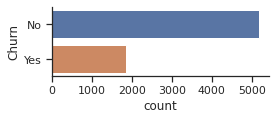

In [81]:
ax = sns.catplot(y="Churn", kind="count", data=df, height=1.6, aspect=2.5, orient='h')


### Numerical features
There are only three numerical columns: 
- tenure, 
- monthly charges and 
- total charges. 


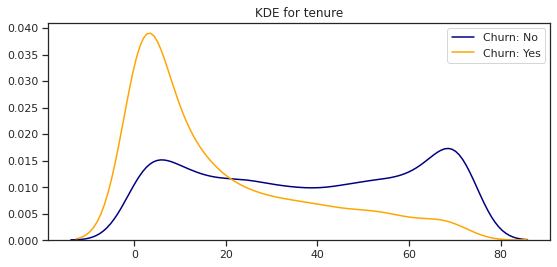

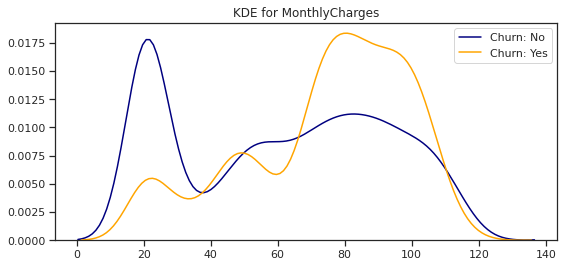

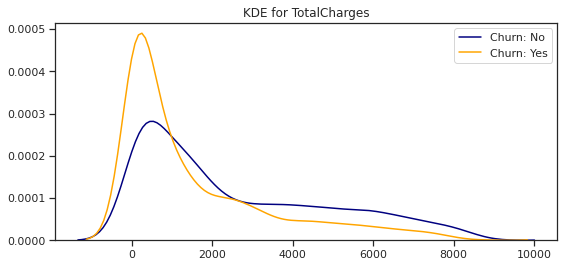

In [82]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Churn'] == 'No'][feature].dropna(), color= 'navy', label= 'Churn: No')
    ax1 = sns.kdeplot(df[df['Churn'] == 'Yes'][feature].dropna(), color= 'orange', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

From the plots above we can conclude that:

- Recent clients are more likely to churn
- Clients with higher MonthlyCharges are also more likely to churn
- Tenure and MonthlyCharges are probably important features

In fact we can see some boundaries when we use scatter plots:

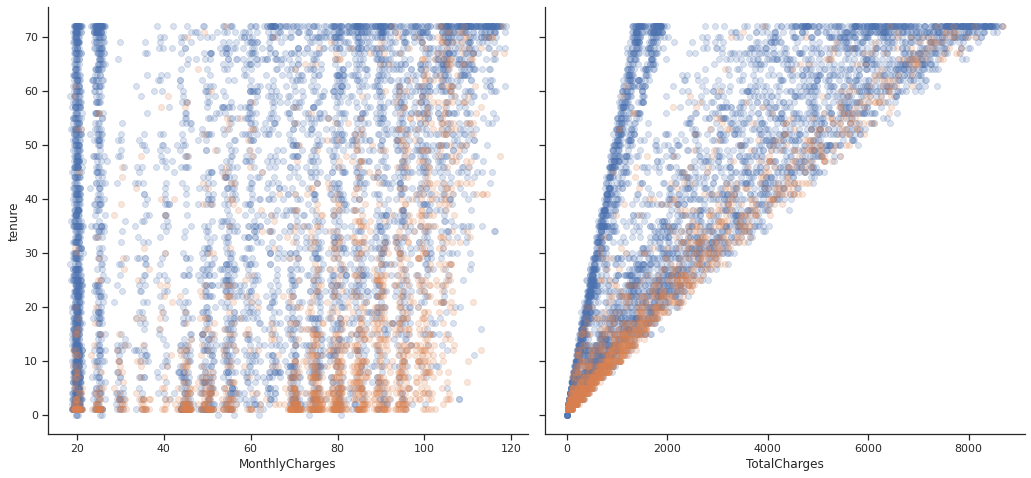

In [83]:
g = sns.PairGrid(
    df, 
    y_vars=["tenure"], 
    x_vars=["MonthlyCharges", "TotalCharges"], 
    height=6.5, hue="Churn", aspect=1.1 )
ax = g.map(plt.scatter, alpha=0.2)

Another feature we can consider is the difference between the MonthlyCharges and the TotalCharges divided by the tenure:

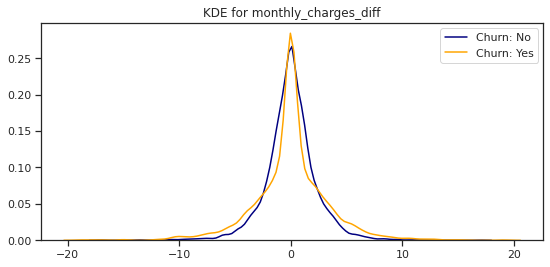

In [84]:
# Calculate features
df['total_charges_to_tenure_ratio'] = df['TotalCharges'] / df['tenure']
df['monthly_charges_diff'] = df['MonthlyCharges'] - df['total_charges_to_tenure_ratio']
kdeplot('monthly_charges_diff')

### Categorical features
This dataset has 16 categorical features:

- 6 binary features (Yes/No)
- 9 features with three unique values each (categories)
- 1 feature with four unique values

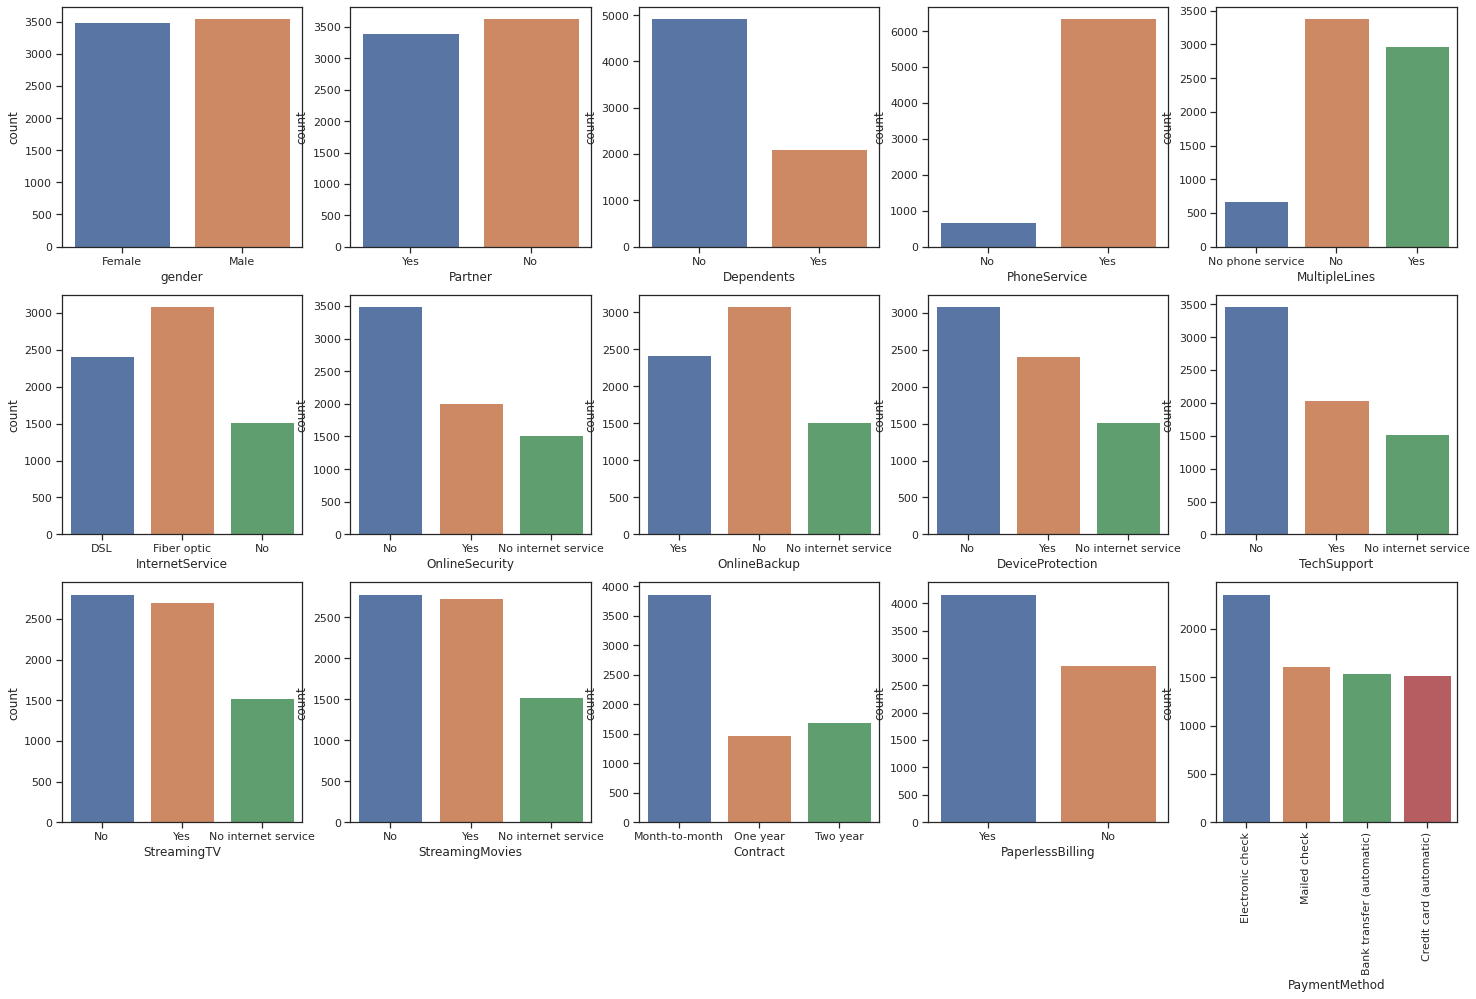

In [85]:
fig, axes = plt.subplots(nrows = 3,ncols = 5,figsize = (25,15))
sns.countplot(x = "gender", data = df, ax=axes[0][0])
sns.countplot(x = "Partner", data = df, ax=axes[0][1])
sns.countplot(x = "Dependents", data = df, ax=axes[0][2])
sns.countplot(x = "PhoneService", data = df, ax=axes[0][3])
sns.countplot(x = "MultipleLines", data = df, ax=axes[0][4])
sns.countplot(x = "InternetService", data = df, ax=axes[1][0])
sns.countplot(x = "OnlineSecurity", data = df, ax=axes[1][1])
sns.countplot(x = "OnlineBackup", data = df, ax=axes[1][2])
sns.countplot(x = "DeviceProtection", data = df, ax=axes[1][3])
sns.countplot(x = "TechSupport", data = df, ax=axes[1][4])
sns.countplot(x = "StreamingTV", data = df, ax=axes[2][0])
sns.countplot(x = "StreamingMovies", data = df, ax=axes[2][1])
sns.countplot(x = "Contract", data = df, ax=axes[2][2])
sns.countplot(x = "PaperlessBilling", data = df, ax=axes[2][3])
ax = sns.countplot(x = "PaymentMethod", data = df, ax=axes[2][4])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show(fig)

#### Gender and Age (SeniorCitizen)

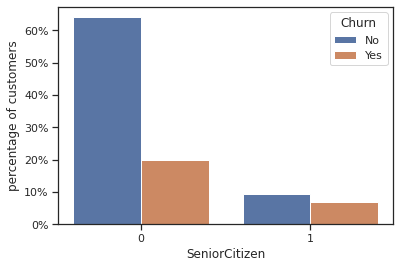

In [86]:
def barplot_percentages(feature, orient='v', axis_name="percentage of customers"):
    ratios = pd.DataFrame()
    g = df.groupby(feature)["Churn"].value_counts().to_frame()
    g = g.rename({"Churn": axis_name}, axis=1).reset_index()
    g[axis_name] = g[axis_name]/len(df)
    if orient == 'v':
        ax = sns.barplot(x=feature, y= axis_name, hue='Churn', data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x= axis_name, y=feature, hue='Churn', data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    ax.plot()
barplot_percentages("SeniorCitizen")

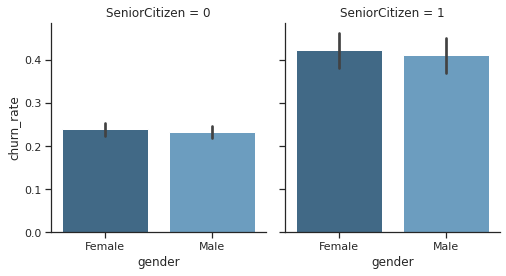

In [87]:
df['churn_rate'] = df['Churn'].replace("No", 0).replace("Yes", 1)
g = sns.FacetGrid(df, col="SeniorCitizen", height=4, aspect=.9)
ax = g.map(sns.barplot, "gender", "churn_rate", palette = "Blues_d", order= ['Female', 'Male'])

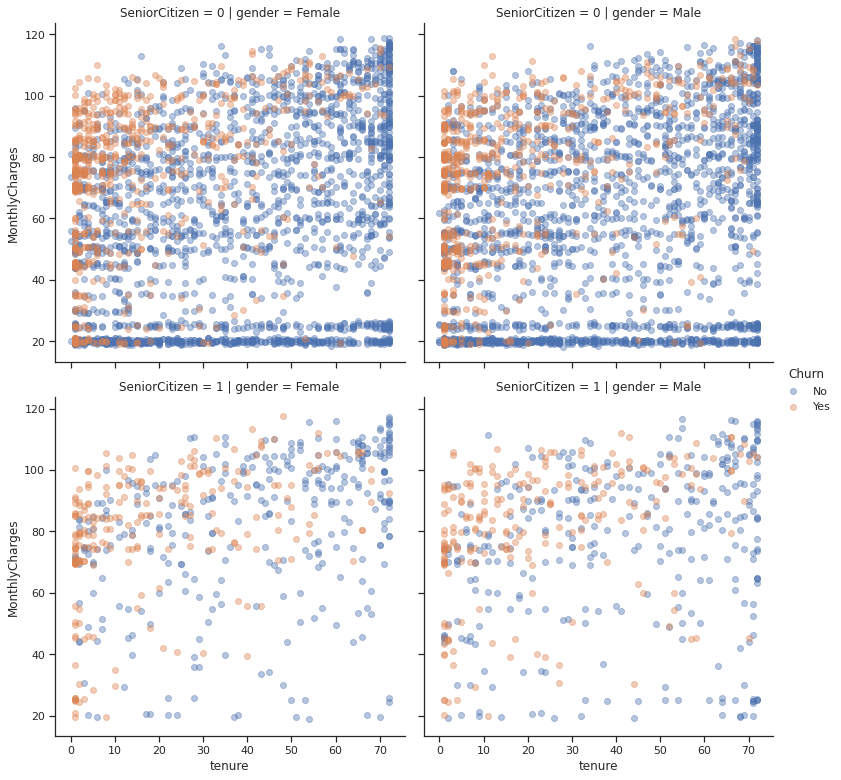

In [88]:
g = sns.FacetGrid(df, row='SeniorCitizen', col="gender", hue="Churn", height=5.5)
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.4)
g.add_legend();

- Gender is not an indicative of churn.
- SeniorCitizens are only 16% of customers, but they have a much higher churn rate: 42% against 23% for non-senior customers.
- There are no special relations between this categorical values and the main numerical features.

#### Partner and dependents


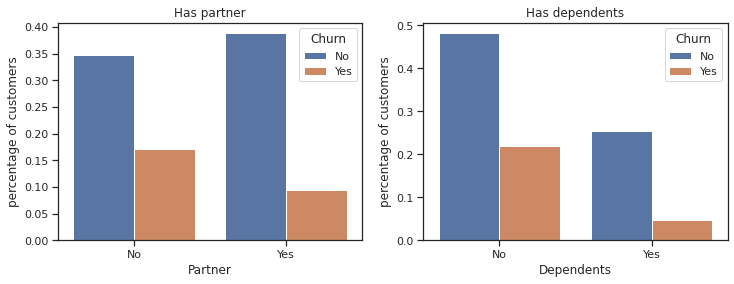

In [89]:
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Has partner")
axis[1].set_title("Has dependents")
axis_y = "percentage of customers"
# Plot Partner column
gp_partner = df.groupby('Partner')["Churn"].value_counts()/len(df)
gp_partner = gp_partner.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= axis_y, hue='Churn', data=gp_partner, ax=axis[0])
# Plot Dependents column
gp_dep = df.groupby('Dependents')["Churn"].value_counts()/len(df)
gp_dep = gp_dep.to_frame().rename({"Churn": axis_y}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= axis_y, hue='Churn', data=gp_dep, ax=axis[1])

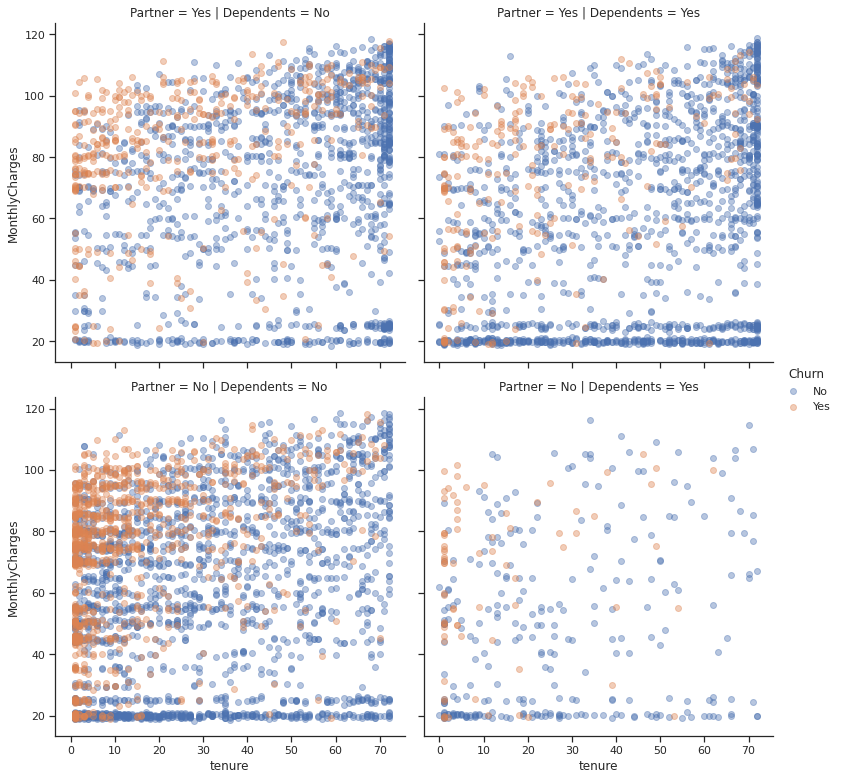

In [90]:
g = sns.FacetGrid(df, row='Partner', col="Dependents", hue="Churn", height=5.5)
g.map(plt.scatter, "tenure", "MonthlyCharges", alpha=0.4)
g.add_legend();

- Customers that doesn't have partners are more likely to churn
- Customers without dependents are also more likely to churn

#### Phone and Internet services
Now let's look at the services that customers are using. There are only two main services: phone and internet but the former has many additionals like online backup and security.

#### Phone services

There are only two features here: if the client has phone and if he has more than one line. Both can be summed up in one chart:

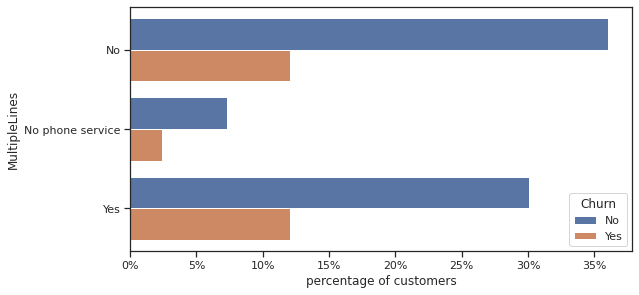

In [91]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("MultipleLines", orient='h')

- Few customers doesn't have phone service
- Customers with multiple lines have a slightly higher churn rate
Let's see how multiple lines affects the monthly charges:

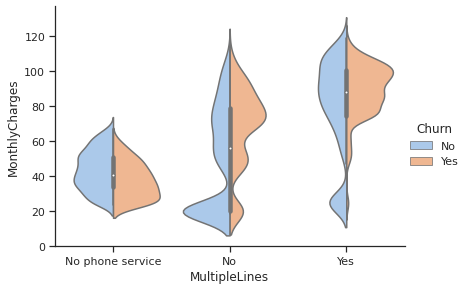

In [92]:
ax = sns.catplot(x="MultipleLines", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

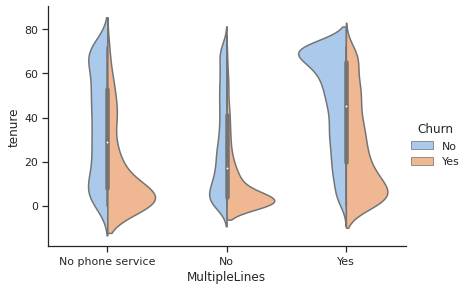

In [93]:
ax = sns.catplot(x="MultipleLines", y="tenure", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

#### Internet Service

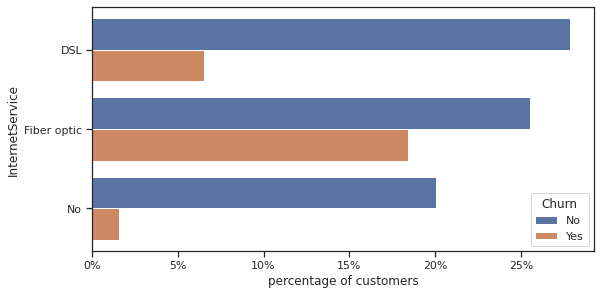

In [94]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("InternetService", orient="h")

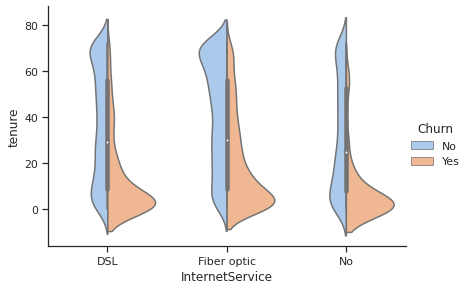

In [95]:
ax = sns.catplot(x="InternetService", y="tenure", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4)

- Clients without internet have a very low churn rate
- Customers with fiber are more probable to churn than those with DSL connection

Comparing the Internet service with monthly charges:

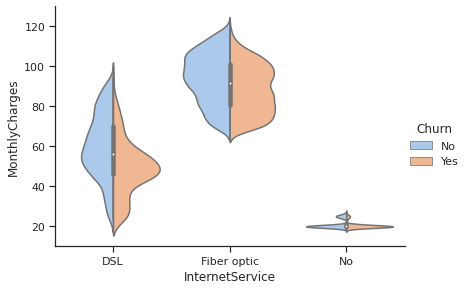

In [96]:
ax = sns.catplot(x="InternetService", y="MonthlyCharges", hue="Churn", kind="violin",
                 split=True, palette="pastel", data=df, height=4.2, aspect=1.4);

It's interesting how customers with DSL (slower connection) and higher charges are less probable to churn.



#### Additional services

There are six additional services for customers with internet:

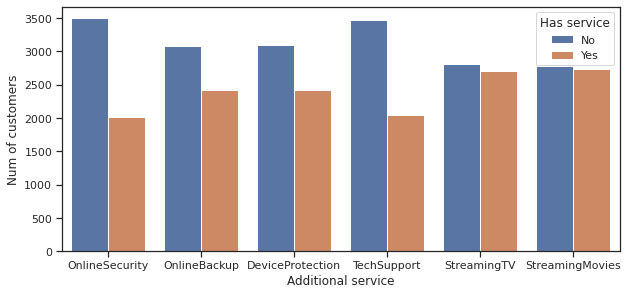

In [97]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(df[df["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x='variable', hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers')
plt.show()

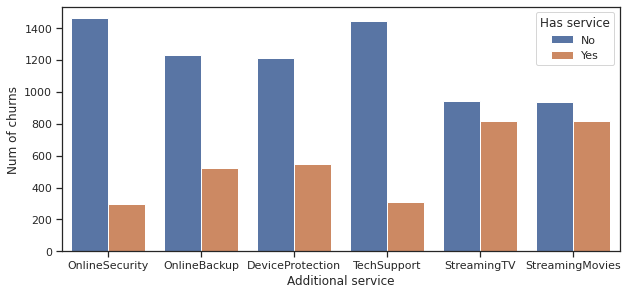

In [98]:
plt.figure(figsize=(10, 4.5))
df1 = df[(df.InternetService != "No") & (df.Churn == "Yes")]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x='variable', hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Num of churns')
plt.show()

The first plot shows the total number of customers for each additional service, while the second shows the number of clients that churn. We can see that:

Customers with the first 4 additionals (security to tech support) are more unlikely to churn
Streaming service is not predictive for churn


#### Contract and Payment


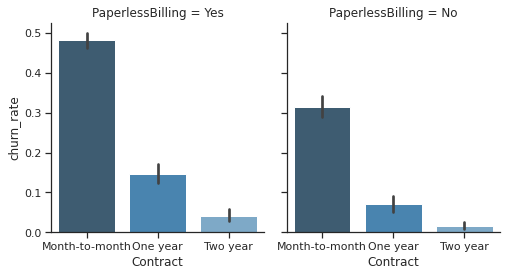

In [99]:
g = sns.FacetGrid(df, col="PaperlessBilling", height=4, aspect=.9)
ax = g.map(sns.barplot, "Contract", "churn_rate", palette = "Blues_d", order= ['Month-to-month', 'One year', 'Two year'])

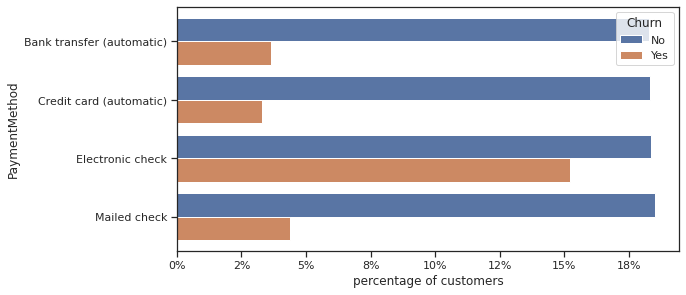

In [100]:
plt.figure(figsize=(9, 4.5))
barplot_percentages("PaymentMethod", orient='h')

A few observations:

- Customers with paperless billing are more probable to churn
- The preferred payment method is Electronic check with around 35% of customers. This method also has a very high churn rate
- Short term contracts have higher churn rates

One and two year contracts probably have contractual fines and therefore customers have to wait untill the end of contract to churn. A time-series dataset would be better to understand this kind of behaviour. Now let's have a look at the relation with numerical features:

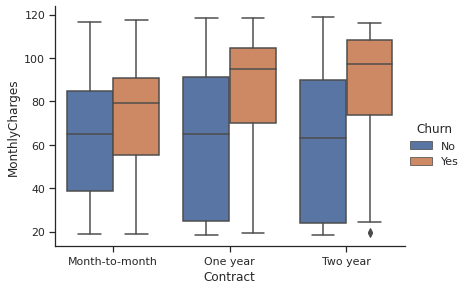

In [101]:
ax = sns.catplot(x="Contract", y="MonthlyCharges", hue="Churn", kind="box", data=df, height=4.2, aspect=1.4)

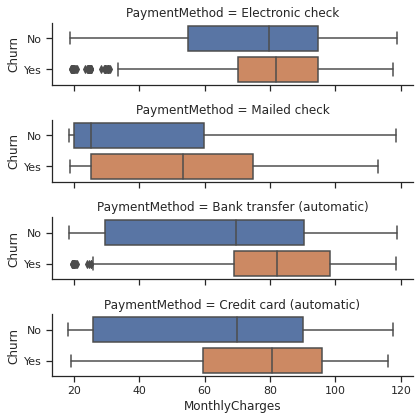

In [102]:
ax = sns.catplot(y="Churn", x="MonthlyCharges", row="PaymentMethod", kind="box", data=df, height=1.5, aspect=4, orient='h')

- Longer contracts are more affected by higher monthly charges (for churn rate).
- Mailed checks have lower charges
- There is a huge gap in charges between customers that churn and those that don't with respect to Mailed Check

### Correlation between features
Correlation heatmap (Pearson method)

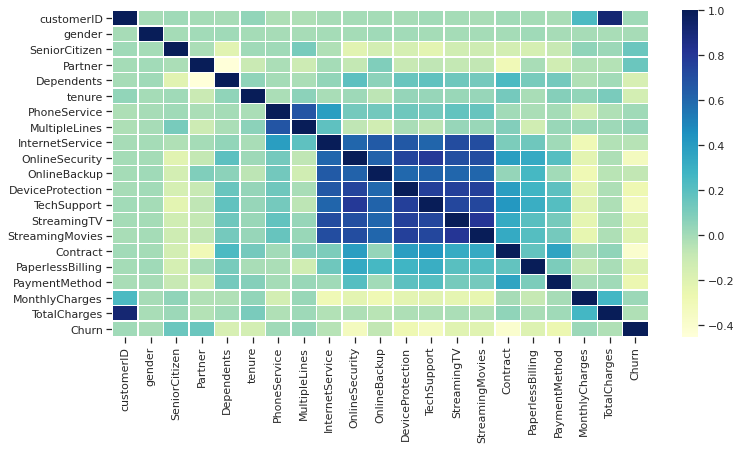

In [103]:
plt.figure(figsize=(12, 6))

corr = df.drop(['churn_rate', 'total_charges_to_tenure_ratio', 'monthly_charges_diff'],axis=1).apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### Feature Importance
To get some preliminary feature importances we will use the Random Forest classifier, an well know decision-tree based model. I've used one-hot encode to encode the categorical features and dropped the 'No' columns for binary features. I've also manually tested a few hyperparameters to get a better model.

The importances are the mean decrease in impurity for each feature across all trees.

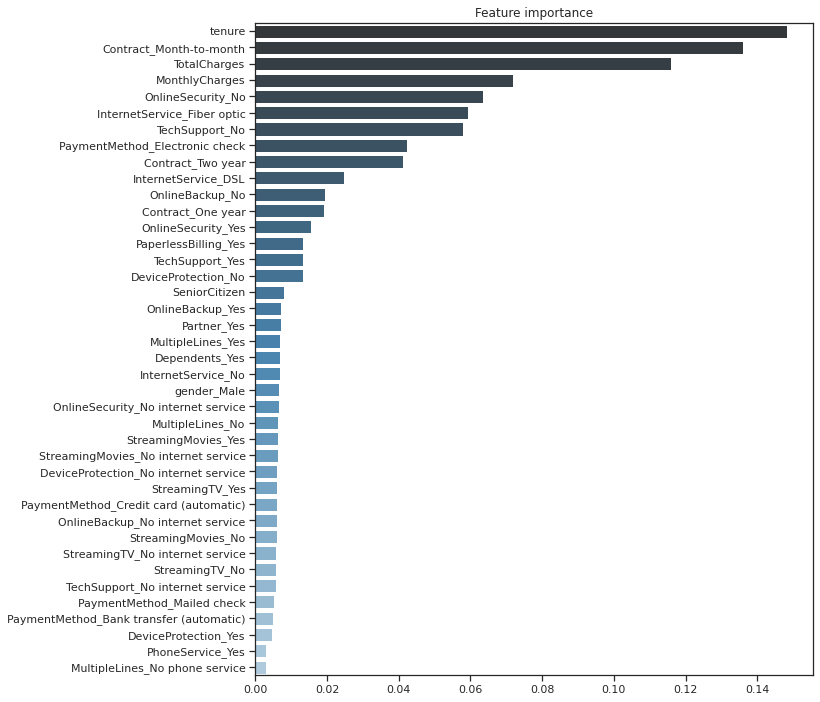

In [104]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
# One-hot encode
df1 = pd.get_dummies(df.drop(['customerID'], axis = 1))
# Drop redundant columns (for features with two unique values)
drop = ['Churn_Yes', 'Churn_No', 'gender_Female', 'Partner_No', 'Dependents_No', 'PhoneService_No', 'PaperlessBilling_No','churn_rate', 'total_charges_to_tenure_ratio', 'monthly_charges_diff']
x, y = df1.drop(drop,axis=1), df1['Churn_Yes']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)

clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

## Preparation

In [117]:
from sklearn.preprocessing import LabelEncoder

def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [118]:
df2 = df.drop(['customerID'], 1).apply(lambda x: object_to_int(x))
df2.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,total_charges_to_tenure_ratio,monthly_charges_diff,churn_rate
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.850000,0,29.850000,-3.814697e-07,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.500000,0,55.573529,1.376471e+00,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.150002,1,54.075001,-2.250008e-01,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.750000,0,40.905556,1.394444e+00,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.649994,1,75.824997,-5.124997e+00,1


## Verification

In [107]:
print ("Rows     : " ,df2.shape[0])
print ("Columns  : " ,df2.shape[1])
print ("\nFeatures : \n" ,df2.columns)
print ("\nMissing values :  ", df2.isnull().sum().values.sum())
print ("\nUnique values :  \n",df2.nunique())

Rows     :  7043
Columns  :  23

Features : 
 Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn',
       'total_charges_to_tenure_ratio', 'monthly_charges_diff', 'churn_rate'],
      dtype='object')

Missing values :   22

Unique values :  
 gender                              2
SeniorCitizen                       2
Partner                             2
Dependents                          2
tenure                             73
PhoneService                        2
MultipleLines                       3
InternetService                     3
OnlineSecurity                      3
OnlineBackup                        3
DeviceProtection                    3
TechSupport                         3
StreamingT

# Machine Learning

<img src="https://1.bp.blogspot.com/-ME24ePzpzIM/UQLWTwurfXI/AAAAAAAAANw/W3EETIroA80/s1600/drop_shadows_background.png">

In [119]:
X = df2.drop(['Churn','churn_rate','total_charges_to_tenure_ratio','monthly_charges_diff'], 1)
y = df2['Churn']


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 101)
# Use candidate classifier

classifiers = [['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1, random_state =50, max_features = "auto",max_leaf_nodes = 30)], 
               ['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['SVM 2:', SVC(probability=True, C=1/0.3, gamma=0.1)],
               ['Neural Network :', MLPClassifier()],
               ['LogisticRegression :', LogisticRegression(max_iter=500)],
               ['SGD Classifier :', SGDClassifier(max_iter=1000, tol=1e-3)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier()],
               ['AdaBoostClassifier :', AdaBoostClassifier()],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier()],
               ['XGB :', XGBClassifier()],
               ['CatBoost :', CatBoostClassifier(logging_level='Silent')]]

predictions_df = pd.DataFrame()
predictions_df['actual_labels'] = y_test

for name,classifier in classifiers:
    classifier = classifier
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    predictions_df[name.strip(" :")] = predictions
    print(name, accuracy_score(y_test, predictions))


DecisionTree : 0.7274662881476224
RandomForest : 0.7927608232789212
Naive Bayes : 0.7487579843860894
KNeighbours : 0.7487579843860894
SVM : 0.7281760113555713
SVM 2: 0.7508871540099361
Neural Network : 0.7877927608232789
LogisticRegression : 0.8019872249822569
SGD Classifier : 0.7295954577714692
ExtraTreesClassifier : 0.7743080198722498
AdaBoostClassifier : 0.7927608232789212
GradientBoostingClassifier:  0.8034066713981547
XGB : 0.7913413768630234
CatBoost : 0.7892122072391767


In [123]:
from sklearn.ensemble import VotingClassifier
clf1 = GradientBoostingClassifier()
clf2 = LogisticRegression(max_iter=500)
clf3 = XGBClassifier()
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_test)
print(accuracy_score(y_test, predictions))

0.801277501774308


## Model Evaluation

In [124]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score

In [125]:
probabilities = eclf1.predict_proba(X_test)
print ("\n Classification report : \n",classification_report(y_test,predictions))
print ("Accuracy   Score : ",accuracy_score(y_test,predictions))
#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
#roc_auc_score
model_roc_auc = roc_auc_score(y_test,predictions) 
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probabilities[:,1])


 Classification report : 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1026
           1       0.68      0.50      0.58       383

    accuracy                           0.80      1409
   macro avg       0.76      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Accuracy   Score :  0.801277501774308
Area under curve :  0.7072804218262511 



Confusion Marix
[[937  89]
 [191 192]]


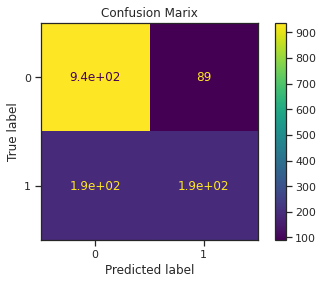

In [126]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(eclf1, X_test, y_test)
disp.ax_.set_title("Confusion Marix")
print("Confusion Marix")
print(disp.confusion_matrix)

# Prediction based on the models used


In [127]:
ids = df["customerID"]

In [128]:
pred_eclf1 = eclf1.predict(df2.drop(columns=["Churn",'churn_rate','total_charges_to_tenure_ratio','monthly_charges_diff']))
out_pred_eclf1 = pd.DataFrame({"customerID":ids,"Prediction":pred_eclf1})
out_pred_eclf1.head()

,customerID,Prediction
0,7590-VHVEG,1
1,5575-GNVDE,0
2,3668-QPYBK,0
3,7795-CFOCW,0
4,9237-HQITU,1


In [129]:
pd.merge(
    df,
    out_pred_eclf1, on="customerID").tail(20)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,total_charges_to_tenure_ratio,monthly_charges_diff,churn_rate,Prediction
7023,1035-IPQPU,Female,1,Yes,No,63,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,103.50,6479.399902,No,102.847617,0.652383,0,0
7024,7398-LXGYX,Male,0,Yes,No,44,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),84.80,3626.350098,No,82.417048,2.382952,0,0
7025,2823-LKABH,Female,0,No,No,18,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Month-to-month,Yes,Bank transfer (automatic),95.05,1679.400024,No,93.300001,1.749999,0,0
7026,8775-CEBBJ,Female,0,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.350006,Yes,44.816667,-0.616667,1,0
7027,0550-DCXLH,Male,0,No,No,13,Yes,No,DSL,No,Yes,No,Yes,Yes,Yes,Month-to-month,No,Mailed check,73.35,931.549988,No,71.657691,1.692309,0,0
7028,9281-CEDRU,Female,0,Yes,No,68,Yes,No,DSL,No,Yes,No,Yes,Yes,No,Two year,No,Bank transfer (automatic),64.10,4326.250000,No,63.621324,0.478676,0,0
7029,2235-DWLJU,Female,1,No,No,6,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,44.40,263.049988,No,43.841665,0.558335,0,1
7030,0871-OPBXW,Female,0,No,No,2,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.05,39.250000,No,19.625000,0.425000,0,0
7031,3605-JISKB,Male,1,Yes,No,55,Yes,Yes,DSL,Yes,Yes,No,No,No,No,One year,No,Credit card (automatic),60.00,3316.100098,No,60.292729,-0.292729,0,0
7032,6894-LFHLY,Male,1,No,No,1,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,75.75,75.750000,Yes,75.750000,0.000000,1,1
